# Домашнее задание 9. Классификация букв для задачи расстановки ударения.

Задание: обучите модель классификации букв для задачи расстановки ударения с помощью методов из библиотеки transformers. Датасет для обучения можно взять из текстового файла dataset.txt.

1. Напишите класс для Dataset/Dataloder и разбейте данные на случайные train / test сплиты в соотношении 50:50. (1 балл)
2. Попробуйте дообучить русскоязычную модель Bert. Посчитайте метрику Accuracy. (1 балл). 
3. При преодолении порога в Accuracy  >0.89: (+3 балла).

Дополнительно можете посмотреть, как разброс классов влияет на ухудшение качества модели на основе трансформерной архитектуры.

## Обзор датасета

Максимальная длина слова в буквах

In [1]:
import pandas as pd
dataTable = pd.read_csv('C:/Users/Home/Downloads/all_accents/all_accents.tsv', delimiter='\t')
testList = list(dataTable['-де'])
maxLen = 0
for word in testList:
  maxLen = max(maxLen, len(word))
print("Максимальная длина слова:", maxLen)

Максимальная длина слова: 56


In [2]:
dataTable.head()

,-де,-д^е
0,-ка,-к^а
1,-либо,-л^ибо
2,-нибудь,-ниб^удь
3,-с,-с
4,-таки,-так^и


Распределение классов:

In [11]:
def get_class_counts(dataTable, column_name='label'):
    """
    Возвращает список с количеством семплов для каждого класса.
    Индекс списка = номер класса, значение = количество семплов.
    """
    max_class = int(dataTable[column_name].max())
    counts = [0] * (max_class + 1)
    
    for class_num in dataTable[column_name]:
        counts[int(class_num)] += 1
    
    return counts


def plot_class_distribution(dataTable, column_name='label'):
    """
    Строит диаграмму распределения классов.
    """
    import matplotlib.pyplot as plt
    
    counts_list = get_class_counts(dataTable, column_name)
    
    plt.figure(figsize=(14, 6))  # Шире холст - сразу больше места
    
    # Только ненулевые классы для отображения
    class_labels = [str(i) for i, count in enumerate(counts_list) if count > 0]
    class_values = [count for count in counts_list if count > 0]
    
    # width - ширина столбца (0.8 стандарт, 0.4-0.5 уже норм)
    bars = plt.bar(class_labels, class_values, 
                  color='skyblue', 
                  edgecolor='black',
                  width=0.5)
    
    plt.xlabel('Класс (позиция ^)')
    plt.ylabel('Количество')
    plt.title('Распределение классов')
    
    # Для цифр можно сместить чуть выше
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., 
                height + (max(class_values) * 0.01),  # Отступ сверху
                f'{int(height)}', 
                ha='center', 
                va='bottom',
                fontsize=9)  # Размер шрифта если надо
    
    plt.tight_layout()
    plt.show()


def print_class_examples(dataTable, examples_column, column_name='label', n_examples=3):
    """
    Выводит статистику по классам с примерами слов.
    Использует get_class_counts для получения количества.
    """
    counts_list = get_class_counts(dataTable, column_name)
    
    print("Статистика по классам:")
    print("Класс | Количество | Примеры")
    print("-" * 50)
    
    for class_num, count in enumerate(counts_list):
        if count > 0:
            examples = ", ".join(
                dataTable[dataTable[column_name] == class_num][examples_column]
                .head(n_examples)
                .tolist()
            )
            print(f"{str(class_num):>5} | {count:10d} | {examples}")

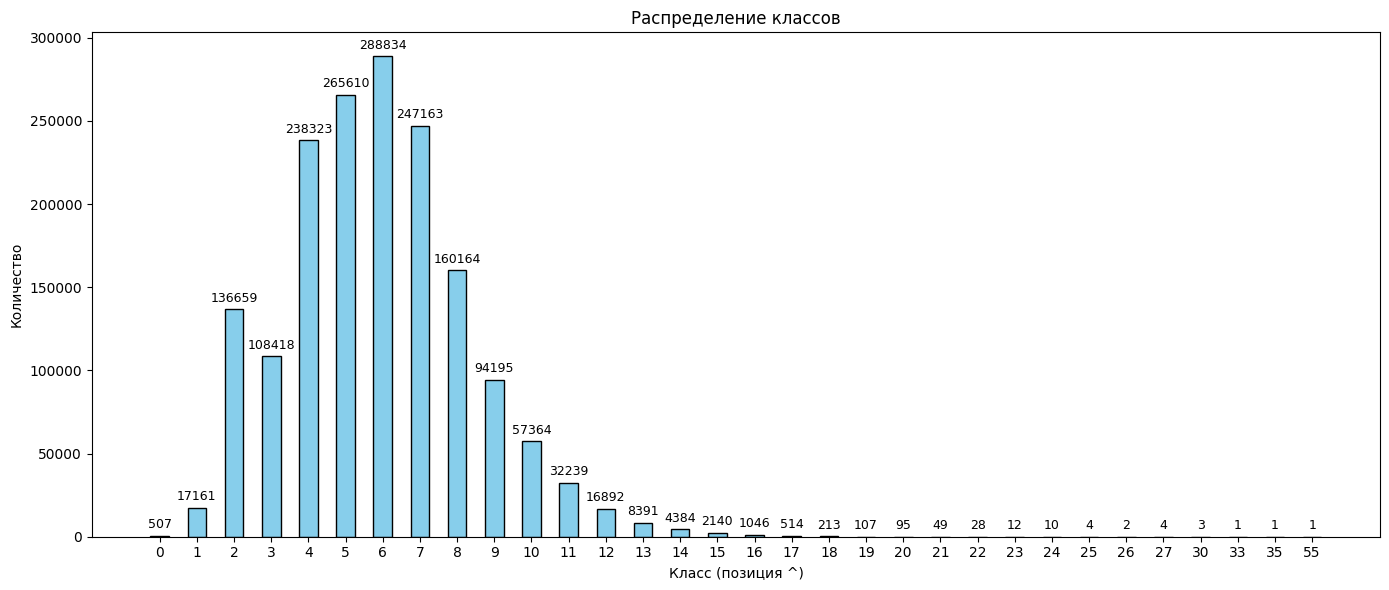

In [12]:
# нулевой класс - ударение отсутствует
def find_caret_position(text):
    if '^' in text:
        return text.index('^') + 1
    return 0

dataTable['label'] = dataTable['-д^е'].apply(find_caret_position)

plot_class_distribution(dataTable, column_name='label')

In [5]:
print_class_examples(dataTable, examples_column='-д^е', column_name='label', n_examples=3)

Статистика по классам:
Класс | Количество | Примеры
--------------------------------------------------
    0 |        507 | -с, ай, айвингхо
    1 |      17161 | ^а, ^аав, ^аава
    2 |     136659 | а^ак, а^ака, а^акам
    3 |     108418 | -к^а, -л^ибо, -т^о
    4 |     238323 | а-к^онто, а-л^я, а-м^ольный
    5 |     265610 | -ниб^удь, -так^и, аалб^оот
    6 |     288834 | аальб^оот, аальб^от, аапст^а
    7 |     247163 | абакан^ович, абакси^альная, абарир^инга
    8 |     160164 | абарогн^оз, абарогн^озия, абастум^ани
    9 |      94195 | абактери^альный, абактэри^альный, абанотуб^ани
   10 |      57364 | абал-хадж^и, аббиатегр^ассо, аббревиат^ур
   11 |      32239 | аббондансь^ери, абдельмадж^ид, абдоминопл^астика
   12 |      16892 | абажуродерж^атель, абдоминализ^ация, абразивно-х^имический
   13 |       8391 | абдоминоаорт^альный, аварийно-пол^евой, аваро-андо-ц^езский
   14 |       4384 | абразивно-мех^анический, абсорбциометр^ический, абхазско-груз^инский
   15 |       2140 | а

Единственная последовательность символов, относящаяся к классу 55, не является словом русского языка. Поэтому её удаляем. Итого остаётся 36 классов.

In [14]:
dataTable = dataTable[dataTable['-д^е'] != "лланвайрпуллгуингиллгогерихуирндробуллллантисилиогогог^ох"]

Итак, всего у нас 36 классов. Как видно, они распределены очень неравномерно. Более того, каких-то классов вообще нет.

Но, если для задач классического ML это была бы катастрофа (так как классика опирается на статистику признаков), то для трансформеров это не всегда проблема. Механизм внимания позволяет улавливать универсальные семантические связи между токенами в последовательности, вне зависимости от того, какому классу она принадлежит. Таким образом, мы берём в расчёт не сами токены и их позицию, а их отношения. Если положение ударения определяется позицией слога относительно каких-либо позиционных маркеров, то трансформер сможет предсказать и абсолютное положение ударения. То есть ему не важно одинаковое распределение классов, а важно, чтобы все примеры имели паттерны выявления нужных маркеров. 

Это ключевой момент для того, чтобы отмести необходимость балансировки классов и попробовать обучить модели без неё. Ведь классы с маленьким количеством примеров и даже отсутствующие классы могут подчиняться тем же универсальным правилам, что и остальные.

## Self-attention механизми

Базовая архитектура self-attention:

![self-attention](https://s1.radikal.cloud/2026/02/08/SNIMOK-EKRANA-2026-02-08-2129300448740f73d324e0.png)

Это ключевая архитектура, которая позволяет трансформерам (в частности моделям семейств Bert, Albert и Deberta) реализовывать так называемый "механизм внимания".
Механизм внимания позволяет решить задачу семантической
Ключевые компоненты:
Q - матрица Query.
K - матрица Key.
V - матрица Value.

Ключевая идея трансформеров. K - это аналог матрицы динамических весов, зависящих от входных токенов, для строк матрицы Q. Это позволяет нам в зависимости от входных данных менять преобразования для Q. Веса как бы трансформируются в зависимости от того, что подаётся на вход. То есть эти веса не предзаданы, а вычисляются на лету для каждой конкретной последовательности. Конкретно для self-attention именно это позволяет модели гибко улавливать связи: например, для слова "он" в предложении веса будут высоки для Key тех слов, которые этот "он" обозначает. Именно это и позволяет запоминать отношения между токенами в Q и информацией о всей последовательности в K, что и показываемся в матрице внимания A. Таким образом, у архитектуры есть контекстная гибкость.

Функция для разбивки данных на train и test

Train distribution:


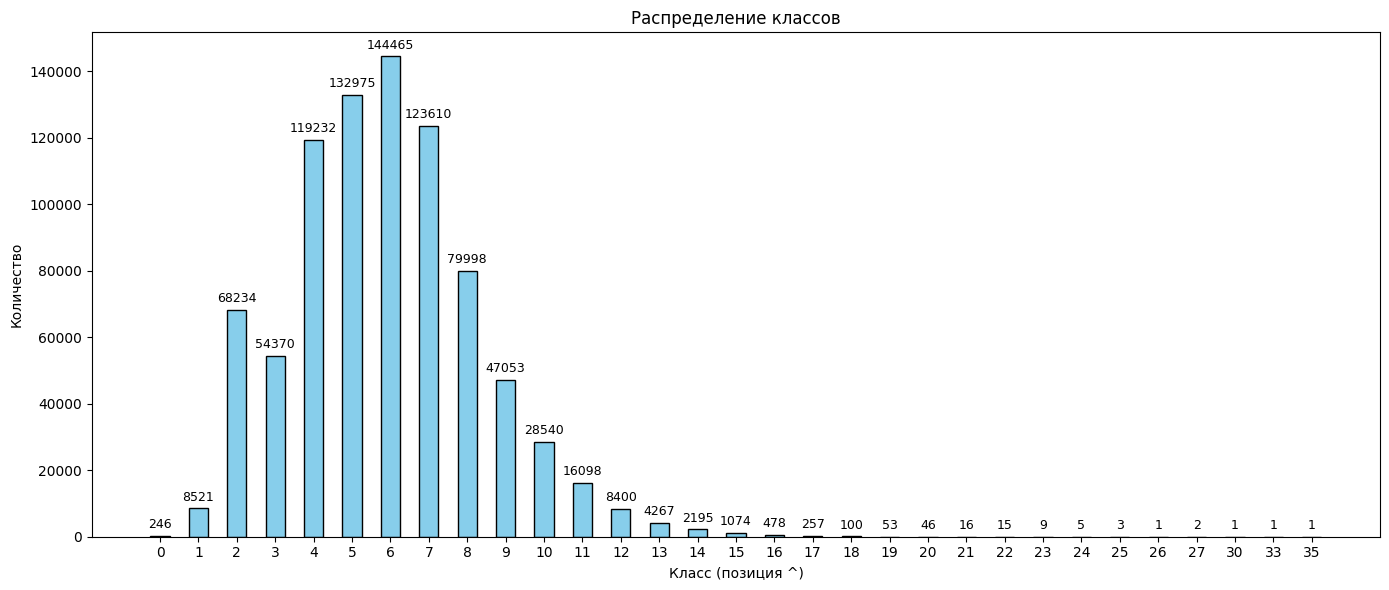

Статистика по классам:
Класс | Количество | Примеры
--------------------------------------------------
    0 |        246 | нио, гнетший, ерзнуть
    1 |       8521 | ^обыскам, ^явная, ^интерференционный
    2 |      68234 | к^омингсов, л^иствий, т^ерека
    3 |      54370 | из^идах, ощ^упай, ли^онская
    4 |     119232 | пер^ильною, отч^ислены, поз^ировавшем
    5 |     132975 | наст^ойчивое, безм^ерна, бодр^ившем
    6 |     144465 | однол^етние, прост^евший, медит^ирующий
    7 |     123610 | проявл^ения, диспут^ируй, серапи^она
    8 |      79998 | экстрав^ертами, змеевик^и, реставр^ировавшуюся
    9 |      47053 | отсоедин^енных, поименов^авшим, дезоморф^инам
   10 |      28540 | предубежд^ена, многостор^онни, транспорт^ирные
   11 |      16098 | индивидуал^исткой, пересоздав^авшийся, предприним^авшимися
   12 |       8400 | распростран^енным, демифологиз^ируйте, помногознач^ительней
   13 |       4267 | гидротормозн^ых, классификаци^онно, немедикамент^озной
   14 |       2195 | 

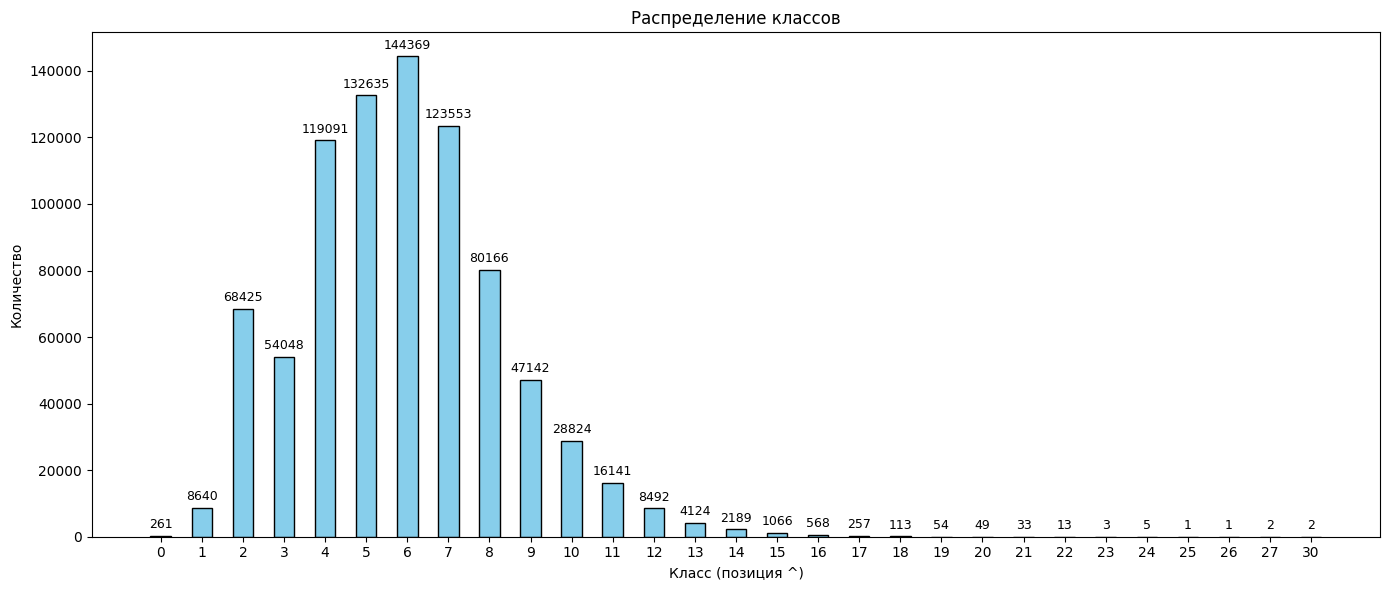

Статистика по классам:
Класс | Количество | Примеры
--------------------------------------------------
    0 |        261 | сгребшийся, кешк, встрепываться
    1 |       8640 | ^альмы, ^яхромскою, ^инкуба
    2 |      68425 | м^одус, м^учившихся, з^ейскими
    3 |      54048 | ив^ановками, ск^уришь, оп^устит
    4 |     119091 | бух^икало, окр^ашенною, нах^одчивейшему
    5 |     132635 | бесш^умности, раст^ягивали, напр^ыскаете
    6 |     144369 | задав^алами, импер^аторские, присм^атривают
    7 |     123553 | теплох^одами, откреп^и, сталев^арам
    8 |      80166 | намолот^ившим, техобсл^уживаниях, неостро^умных
    9 |      47142 | перерожд^ающего, приструг^ай, газоразр^ядными
   10 |      28824 | эволюцион^ировавшими, взгромозд^ишь, полуторат^онных
   11 |      16141 | червоноарм^ейское, фенолфтале^ину, противосам^олетною
   12 |       8492 | предостереж^енном, малосовмест^имый, полупарализ^ованному
   13 |       4124 | внешнеэконом^ическую, десенсибилиз^ируйте, реакклиматиз^ируе

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(dataTable, test_size=0.5, random_state=42, shuffle=True)

print("Train distribution:")
plot_class_distribution(train_df, 'label')
print_class_examples(train_df, '-д^е', 'label', 3)

print("\nTest distribution:")
plot_class_distribution(test_df, 'label')
print_class_examples(test_df, '-д^е', 'label', 3)

## Адаптация данных под обучение трансформера

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader

class WordsDataset(Dataset):
    def __init__(self, dataframe, text_column, label_column, maxWordLength, tokenizer):
        super(WordsDataset, self).__init__()
        self.dataframe = dataframe.reset_index(drop=True)
        self.text_column = text_column
        self.label_column = label_column
        self.maxWordLength = maxWordLength
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        word = self.dataframe.loc[idx, self.text_column]
        label = self.dataframe.loc[idx, self.label_column]
        
        itemDict = self.tokenizer(list(word),
                                  max_length=self.maxWordLength,
                                  padding='max_length',
                                  truncation=True,
                                  is_split_into_words=True)
        itemDict['input_ids'] = torch.tensor(itemDict['input_ids'], dtype=torch.long)
        itemDict['token_type_ids'] = torch.tensor(itemDict['token_type_ids'], dtype=torch.long)
        itemDict['attention_mask'] = torch.tensor(itemDict['attention_mask'], dtype=torch.long)
        itemDict['label'] = torch.tensor(label, dtype=torch.long)
        return itemDict

In [10]:
def create_dataloaders(train_dataset, test_dataset, batch_size):
    train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size, shuffle=False)
    return train_loader, test_loader

In [11]:
from tqdm import tqdm
import time
import torch

def train_and_evaluate(model, optimizer, trainLoader, valLoader, device, model_name, epochs=10):
    """
    Обучение с прогресс-баром для батчей и оптимизациями
    """
    model.to(device)
    
    train_losses = []
    val_accuracies = []
    
    print(f"🚀 Начинаем обучение {model_name}")
    print(f"📊 Размер датасета: {len(trainLoader.dataset):,} примеров")
    print(f"🎯 Batch size: {trainLoader.batch_size}")
    print(f"🔄 Батчей в эпохе: {len(trainLoader)}")
    print("=" * 60)
    
    total_start_time = time.time()
    
    for epoch in range(epochs):
        epoch_start_time = time.time()
        
        # ========== ОБУЧЕНИЕ С ПРОГРЕСС-БАРОМ ==========
        model.train()
        epoch_loss = 0
        total_samples = 0
        
        # Создаем прогресс-бар для батчей
        train_pbar = tqdm(
            trainLoader, 
            desc=f'Epoch {epoch+1:2d}/{epochs} [Train]', 
            unit='batch',
            leave=False,
            bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}'
        )
        
        for batch_idx, batch in enumerate(train_pbar):
            # Быстрая загрузка на GPU
            input_ids = batch['input_ids'].to(device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(device, non_blocking=True)
            labels = batch['label'].to(device, non_blocking=True)
            
            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping для стабильности
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            # Сбор статистики
            epoch_loss += loss.item() * input_ids.size(0)
            total_samples += input_ids.size(0)
            
            # Обновляем прогресс-бар
            current_loss = loss.item()
            avg_loss_so_far = epoch_loss / total_samples if total_samples > 0 else 0
            
            # Расчет времени и скорости
            elapsed_time = time.time() - epoch_start_time
            samples_per_sec = total_samples / elapsed_time if elapsed_time > 0 else 0
            estimated_total = elapsed_time / (batch_idx + 1) * len(trainLoader)
            remaining_time = estimated_total - elapsed_time
            
            # Форматируем информацию для отображения
            train_pbar.set_postfix({
                'loss': f'{current_loss:.3f}',
                'avg': f'{avg_loss_so_far:.3f}',
                'speed': f'{samples_per_sec:.0f}/s',
                'ETA': f'{remaining_time/60:.1f}m'
            })
            
            # Очистка кэша каждые 50 батчей
            if batch_idx % 50 == 0:
                torch.cuda.empty_cache()
        
        avg_train_loss = epoch_loss / total_samples if total_samples > 0 else 0
        train_losses.append(avg_train_loss)
        
        # ========== ВАЛИДАЦИЯ С ПРОГРЕСС-БАРОМ ==========
        model.eval()
        correct = 0
        total = 0
        
        val_pbar = tqdm(
            valLoader,
            desc=f'Epoch {epoch+1:2d}/{epochs} [Val]',
            unit='batch',
            leave=False,
            bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}'
        )
        
        with torch.no_grad():
            for batch in val_pbar:
                input_ids = batch['input_ids'].to(device, non_blocking=True)
                attention_mask = batch['attention_mask'].to(device, non_blocking=True)
                labels = batch['label'].to(device, non_blocking=True)
                
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
                
                logits = outputs.logits
                predicted = torch.argmax(logits, dim=-1)
                
                batch_correct = (predicted == labels).sum().item()
                batch_total = labels.size(0)
                
                correct += batch_correct
                total += batch_total
                
                current_acc = batch_correct / batch_total if batch_total > 0 else 0
                overall_acc = correct / total if total > 0 else 0
                
                val_pbar.set_postfix({
                    'batch_acc': f'{current_acc:.3f}',
                    'overall': f'{overall_acc:.3f}'
                })
        
        val_acc = correct / total if total > 0 else 0
        val_accuracies.append(val_acc)
        
        # ========== ВЫВОД СТАТИСТИКИ ЭПОХИ ==========
        epoch_time = time.time() - epoch_start_time
        samples_per_sec = total_samples / epoch_time if epoch_time > 0 else 0
        
        print(f"\n📊 {model_name} | Эпоха {epoch+1:2d}/{epochs}")
        print(f"   ⏱ Время: {epoch_time:.1f}s ({epoch_time/60:.1f} мин)")
        print(f"   📉 Loss: {avg_train_loss:.4f}")
        print(f"   🎯 Accuracy: {val_acc:.4f} ({correct}/{total})")
        print(f"   🚀 Скорость: {samples_per_sec:.0f} samp/sec")
        print(f"   📈 LR: {optimizer.param_groups[0]['lr']:.2e}")
        
        # Мониторинг памяти GPU
        if torch.cuda.is_available():
            memory_used = torch.cuda.memory_allocated() / 1e9
            memory_cached = torch.cuda.memory_reserved() / 1e9
            print(f"   🧠 GPU память: {memory_used:.1f}GB / {memory_cached:.1f}GB")
        
        print("-" * 60)
    
    # ========== ИТОГОВАЯ СТАТИСТИКА ==========
    total_time = time.time() - total_start_time
    
    print(f"\n✅ ОБУЧЕНИЕ ЗАВЕРШЕНО!")
    print(f"   ⏱ Общее время: {total_time:.1f}s ({total_time/60:.1f} мин)")
    print(f"   🎯 Финальная точность: {val_accuracies[-1]:.4f}")
    print(f"   🏆 Лучшая точность: {max(val_accuracies):.4f}")
    print(f"   📉 Финальный loss: {train_losses[-1]:.4f}")
    print("=" * 60)
    
    # ========== ВИЗУАЛИЗАЦИЯ ==========
    import matplotlib.pyplot as plt
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # График потерь
    ax1.plot(range(1, epochs+1), train_losses, 'b-o', linewidth=2, markersize=8, label='Train Loss')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title(f'{model_name} - Training Loss', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(range(1, epochs+1))
    
    # График точности
    ax2.plot(range(1, epochs+1), val_accuracies, 'g-s', linewidth=2, markersize=8, label='Val Accuracy')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy', fontsize=12)
    ax2.set_title(f'{model_name} - Validation Accuracy', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.set_xticks(range(1, epochs+1))
    ax2.set_ylim([0, 1.05])  # Accuracy от 0 до 1
    
    plt.suptitle(f'Результаты обучения {model_name}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return train_losses, val_accuracies

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


## Обучение Bert

MultiHead Attention (используется в Bert):

![MultiHead](https://s3.radikal.cloud/2026/02/10/SNIMOK-EKRANA-2026-02-10-053152ea8eb9275b661c2c.png)

Суть:

Каждая голова учится разным паттернам внимания:

- Голова 1: Синтаксические связи (субъект-глагол)

- Голова 2: Семантические связи (синонимы)

- Голова h: Длинные зависимости

Объединяем → получаем богатое представление.

В BERT нужно подавать батчи в формате индексы токенов (inputIds), маска внимания токенов (attention_mask) для выделения полезной информации, маска целевого класса (индекс буквы с ударением)

c:\Program Files\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading weights: 100%|██████████| 199/199 [00:00<00:00, 648.46it/s, Materializing param=bert.pooler.dense.weight]                               
BertForSequenceClassification LOAD REPORT from: DeepPavlov/rubert-base-cased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.decoder.bias               | UNEXPECTED | 
bert.embeddings.position_ids               | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED 

=== BERT Training ===


🚀 Начинаем обучение BERT
📊 Размер датасета: 840,266 примеров
🎯 Batch size: 500
🔄 Батчей в эпохе: 1681



📊 BERT | Эпоха  1/10
   ⏱ Время: 1669.3s (27.8 мин)
   📉 Loss: 0.7974
   🎯 Accuracy: 0.8602 (722815/840267)
   🚀 Скорость: 503 samp/sec
   📈 LR: 2.00e-05
   🧠 GPU память: 2.9GB / 14.7GB
------------------------------------------------------------



📊 BERT | Эпоха  2/10
   ⏱ Время: 1645.7s (27.4 мин)
   📉 Loss: 0.3550
   🎯 Accuracy: 0.8992 (755576/840267)
   🚀 Скорость: 511 samp/sec
   📈 LR: 2.00e-05
   🧠 GPU память: 2.9GB / 14.7GB
------------------------------------------------------------



📊 BERT | Эпоха  3/10
   ⏱ Время: 1669.9s (27.8 мин)
   📉 Loss: 0.2657
   🎯 Accuracy: 0.9224 (775043/840267)
   🚀 Скорость: 503 samp/sec
   📈 LR: 2.00e-05
   🧠 GPU память: 2.9GB / 14.7GB
------------------------------------------------------------



📊 BERT | Эпоха  4/10
   ⏱ Время: 1657.3s (27.6 мин)
   📉 Loss: 0.2147
   🎯 Accuracy: 0.9384 (788514/840267)
   🚀 Скорость: 507 samp/sec
   📈 LR: 2.00e-05
   🧠 GPU память: 2.9GB / 14.7GB
------------------------------------------------------------



📊 BERT | Эпоха  5/10
   ⏱ Время: 1633.2s (27.2 мин)
   📉 Loss: 0.1799
   🎯 Accuracy: 0.9459 (794802/840267)
   🚀 Скорость: 514 samp/sec
   📈 LR: 2.00e-05
   🧠 GPU память: 2.9GB / 14.7GB
------------------------------------------------------------



📊 BERT | Эпоха  6/10
   ⏱ Время: 1574.1s (26.2 мин)
   📉 Loss: 0.1548
   🎯 Accuracy: 0.9522 (800126/840267)
   🚀 Скорость: 534 samp/sec
   📈 LR: 2.00e-05
   🧠 GPU память: 2.9GB / 14.7GB
------------------------------------------------------------



📊 BERT | Эпоха  7/10
   ⏱ Время: 1612.7s (26.9 мин)
   📉 Loss: 0.1355
   🎯 Accuracy: 0.9564 (803606/840267)
   🚀 Скорость: 521 samp/sec
   📈 LR: 2.00e-05
   🧠 GPU память: 2.9GB / 14.7GB
------------------------------------------------------------



📊 BERT | Эпоха  8/10
   ⏱ Время: 1643.1s (27.4 мин)
   📉 Loss: 0.1203
   🎯 Accuracy: 0.9577 (804762/840267)
   🚀 Скорость: 511 samp/sec
   📈 LR: 2.00e-05
   🧠 GPU память: 2.9GB / 14.7GB
------------------------------------------------------------



📊 BERT | Эпоха  9/10
   ⏱ Время: 1642.2s (27.4 мин)
   📉 Loss: 0.1078
   🎯 Accuracy: 0.9606 (807126/840267)
   🚀 Скорость: 512 samp/sec
   📈 LR: 2.00e-05
   🧠 GPU память: 2.9GB / 14.7GB
------------------------------------------------------------



📊 BERT | Эпоха 10/10
   ⏱ Время: 1574.9s (26.2 мин)
   📉 Loss: 0.0964
   🎯 Accuracy: 0.9632 (809365/840267)
   🚀 Скорость: 534 samp/sec
   📈 LR: 2.00e-05
   🧠 GPU память: 2.9GB / 14.7GB
------------------------------------------------------------

✅ ОБУЧЕНИЕ ЗАВЕРШЕНО!
   ⏱ Общее время: 16322.4s (272.0 мин)
   🎯 Финальная точность: 0.9632
   🏆 Лучшая точность: 0.9632
   📉 Финальный loss: 0.0964


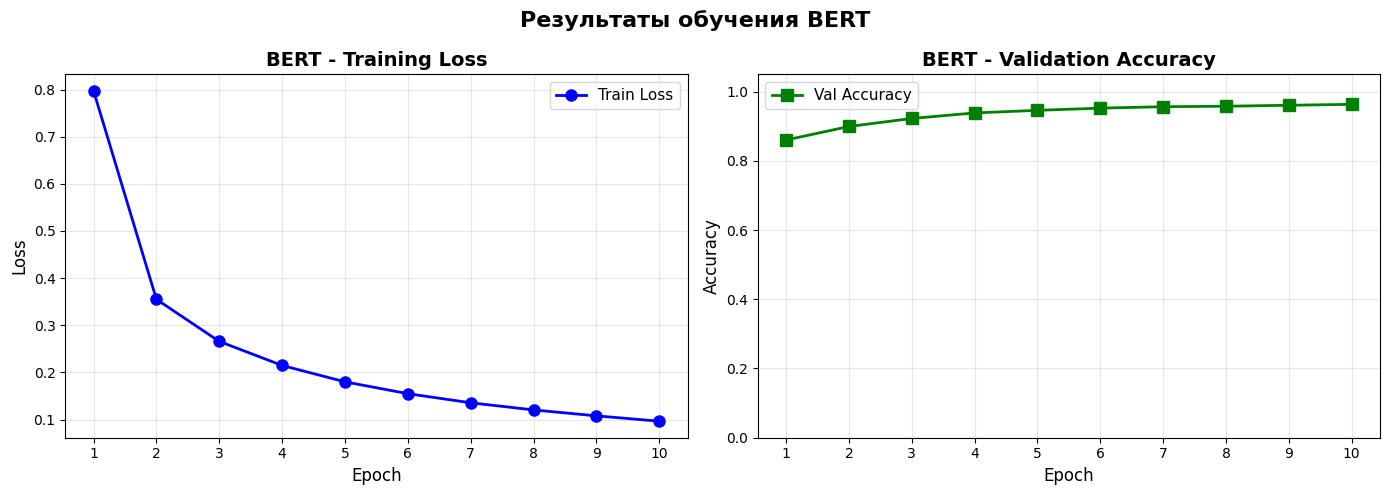

BERT Final Val Accuracy: 0.9632


In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer
from torch.optim import AdamW

bert_tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')

bert_train_dataset = WordsDataset(train_df, '-де', 'label', 36, bert_tokenizer)
bert_test_dataset = WordsDataset(test_df, '-де', 'label', 36, bert_tokenizer)

bert_train_loader, bert_test_loader = create_dataloaders(bert_train_dataset, bert_test_dataset, batch_size=500)

bert_model = BertForSequenceClassification.from_pretrained(
    'DeepPavlov/rubert-base-cased',
    num_labels=36
)

bert_optimizer = AdamW(bert_model.parameters(), lr=2e-5)

print("=== BERT Training ===")
bert_losses, bert_val_acc = train_and_evaluate(
    bert_model, bert_optimizer, bert_train_loader, bert_test_loader, 
    device, "BERT", epochs=10
)
print(f"BERT Final Val Accuracy: {bert_val_acc[-1]:.4f}")

In [17]:
from sklearn.metrics import precision_score, confusion_matrix
import numpy as np

def simple_class_precisions(model, test_loader, train_df, device, num_classes=36):
    """
    Простая версия - только список precision по классам
    Количество примеров БЕРЁТСЯ ИЗ TRAIN датасета
    """
    print("📊 PRECISION ПО КЛАССАМ")
    print("=" * 60)
    
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=-1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Получаем количество примеров из TRAIN датасета
    train_counts = get_class_counts(train_df, 'label')
    
    print("\nКласс | Precision | Примеров в train")
    print("-" * 40)
    
    for class_id in sorted(np.unique(all_labels)):
        tp = np.sum((all_preds == class_id) & (all_labels == class_id))
        fp = np.sum((all_preds == class_id) & (all_labels != class_id))
        train_support = train_counts[class_id] if class_id < len(train_counts) else 0
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        
        # Цветовая индикация
        if precision >= 0.8:
            marker = "✅"
        elif precision >= 0.5:
            marker = "🟨"
        else:
            marker = "❌"
        
        print(f"{marker} {class_id:3d}   |  {precision:.4f}    |  {train_support:5d}")
    
    # Общая статистика
    all_precisions = []
    for class_id in np.unique(all_labels):
        tp = np.sum((all_preds == class_id) & (all_labels == class_id))
        fp = np.sum((all_preds == class_id) & (all_labels != class_id))
        if tp + fp > 0:
            all_precisions.append(tp / (tp + fp))
    
    print("-" * 40)
    print(f"Средняя precision: {np.mean(all_precisions):.4f}")
    print(f"Медианная precision: {np.median(all_precisions):.4f}")

# Запуск
simple_class_precisions(bert_model, bert_test_loader, train_df, device, num_classes=36)

📊 PRECISION ПО КЛАССАМ

Класс | Precision | Примеров в train
----------------------------------------
🟨   0   |  0.7706    |    246
✅   1   |  0.8473    |   8521
✅   2   |  0.9221    |  68234
✅   3   |  0.9486    |  54370
✅   4   |  0.9496    |  119232
✅   5   |  0.9634    |  132975
✅   6   |  0.9740    |  144465
✅   7   |  0.9754    |  123610
✅   8   |  0.9820    |  79998
✅   9   |  0.9848    |  47053
✅  10   |  0.9808    |  28540
✅  11   |  0.9807    |  16098
✅  12   |  0.9712    |   8400
✅  13   |  0.9714    |   4267
✅  14   |  0.9550    |   2195
✅  15   |  0.9432    |   1074
✅  16   |  0.9218    |    478
✅  17   |  0.8000    |    257
🟨  18   |  0.5149    |    100
❌  19   |  0.4706    |     53
❌  20   |  0.2677    |     46
✅  21   |  1.0000    |     16
❌  22   |  0.3333    |     15
❌  23   |  0.0000    |      9
🟨  24   |  0.5000    |      5
❌  25   |  0.0000    |      3
❌  26   |  0.0000    |      1
❌  27   |  0.0000    |      2
❌  30   |  0.0000    |      1
------------------------

По итогу с bert мы видим, что дисбаланс классов для данной задачи является причиной плохой точности предсказаний только на тех классах, где количество примеров в train чрезвычайно мало. Начиная с количества 250+ примеров класса, модель предсказываает уже достаточно точно. Таким образом, модель смогла выучить обобщающие паттерны, основанные на связях между токенами, которые позволили правильно поставить ударение даже на достаточно редких классах.